# Humpback Whale ID - data analysis

In this notebook, I examine the provided data for Kaggle's Humpack Whale ID challenge.

In [149]:
import math
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from tqdm import tqdm

%matplotlib inline

In [18]:
train_df = pd.read_csv('data/train.csv')

In [23]:
np.random.seed(42)

In [240]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread('data/train/' + filename) for filename in filenames]
    
    return plot_images(imgs, labels, rows)
    
        
def plot_images(imgs, labels, rows=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(13, 8))

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

## Exploring the dataset

In [123]:
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


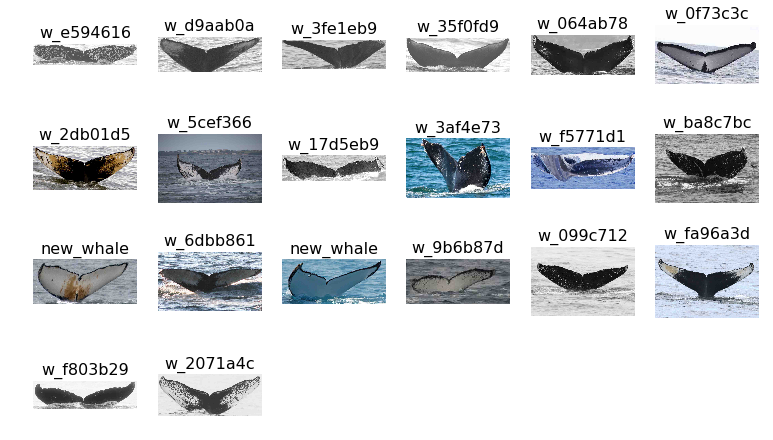

In [241]:
rand_rows = train_df.sample(frac=1.)[:20]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

The competition states that it's hard because: "there are only a few examples for each of 3,000+ whale ids", so let's take a look at the breakdown of number of image per category.

In [57]:
num_categories = len(train_df['Id'].unique())
     
print(f'Number of categories: {num_categories}')

Number of categories: 4251


There appear to be too many categories to graph count by category, so let's instead graph the number of categories by the number of images in the category.

In [43]:
size_buckets = {}

In [44]:
for i in train_df['Id'].value_counts().values:
    size_buckets[i] = size_buckets.get(i, 0) + 1

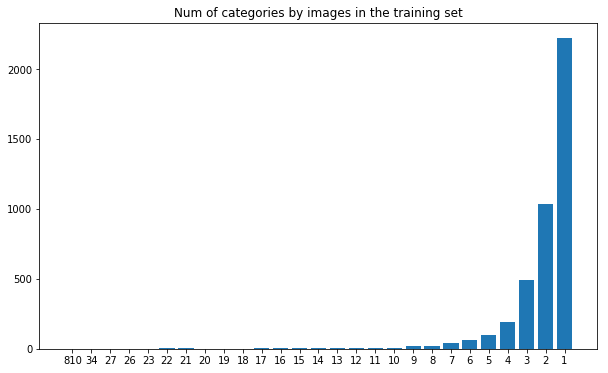

In [186]:
plt.figure(figsize=(10, 6))

plt.bar(range(len(size_buckets)), list(size_buckets.values()), align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys()))
plt.title("Num of categories by images in the training set")

plt.show()

As we can see, the vast majority of classes only have a single image in them. This is going to make predictions very difficult for most conventional image classification models.

In [89]:
train_df['Id'].value_counts().head(3)

new_whale    810
w_1287fbc     34
w_98baff9     27
Name: Id, dtype: int64

In [64]:
total = len(train_df['Id'])
print(f'Total images in training set {total}')

Total images in training set 9850


New whale is the biggest category with 810, followed by `w_1287fbc`. New whale, I believe, is any whale that isn't in scientist's database. Since we can pick 5 potential labels per id, it's probably going to make sense to always include new_whale in our prediction set, since there's always an 8.2% change that's the right one. Let's take a look at one of the classes, to get a sense what flute looks like from the same whale.

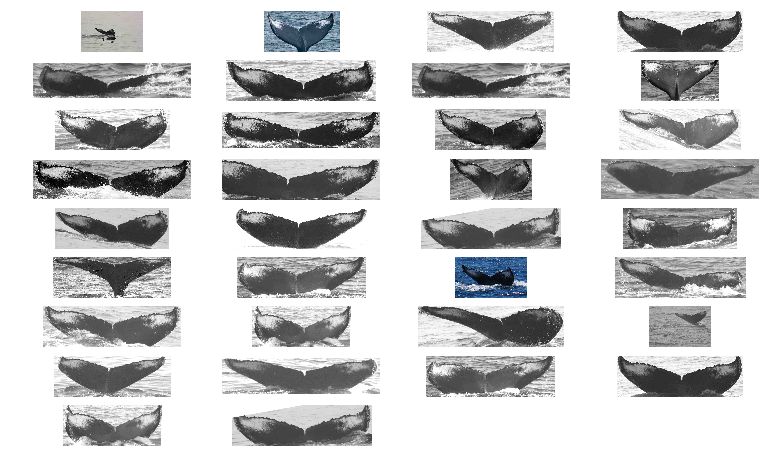

In [103]:
w_1287fbc = train_df[train_df['Id'] == 'w_1287fbc']
plot_images(list(w_1287fbc['Image']), None, rows=9)

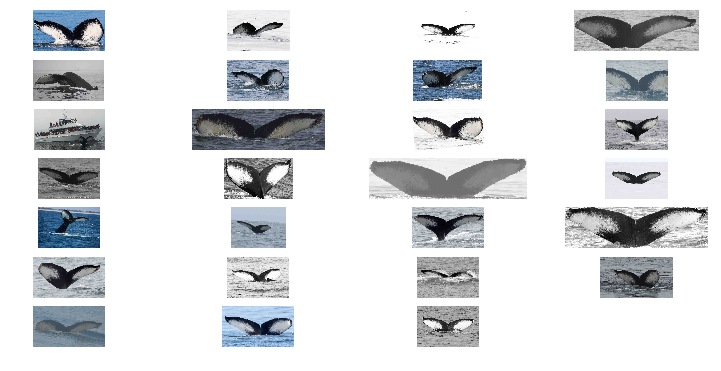

In [104]:
w_98baff9 = train_df[train_df['Id'] == 'w_98baff9']
plot_images(list(w_98baff9['Image']), None, rows=9)

It's very difficult to build a validation set when most classes only have 1 image, so my thinking is to perform some aggressive data augmentation on the classes with < 10 images before creating a train/validation split. Let's take a look at a few examples of whales with only one example.

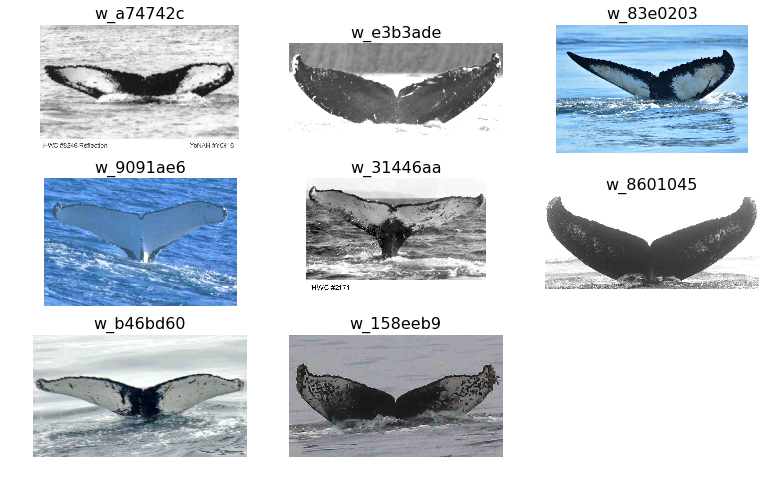

In [114]:
one_image_ids = train_df['Id'].value_counts().tail(8).keys()
one_image_filenames = []
labels = []
for i in one_image_ids:
    one_image_filenames.extend(list(train_df[train_df['Id'] == i]['Image']))
    labels.append(i)
    
plot_images(one_image_filenames, labels, rows=3)

From these small sample sizes, it seems like > 50% of images are black and white, suggesting that a good initial augementation might be to just convert colour images to greyscale and add to the training set. Let's confirm that by looking at a sample of the images.

In [120]:
def is_grey_scale(img_path):
    """Thanks to https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli"""
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

In [142]:
is_grey = [is_grey_scale(f'data/train/{i}') for i in train_df['Image'].sample(frac=0.1)]

In [143]:
grey_perc = round(sum([i for i in is_grey]) / len([i for i in is_grey]) * 100, 2)
print(f"% of grey images: {grey_perc}")

% of grey images: 49.64


It might also be worth capturing the size of the images so we can get a sense of what we're dealing with.

In [151]:
img_sizes = Counter([Image.open(f'data/train/{i}').size for i in train_df['Image']])

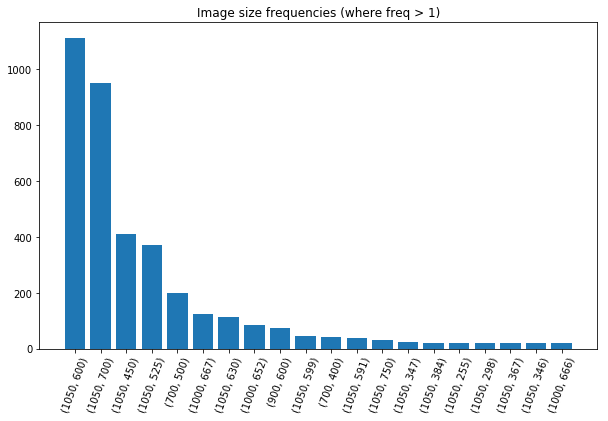

In [182]:
size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")

plt.show()

## Data Augmentations

Keras comes with a number of handy data augmentions, so let's take a look at each one and see if any are going to make sense for this task.

In [192]:
from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift, transform_matrix_offset_center, img_to_array)

In [191]:
img = Image.open('./data/train/ff38054f.jpg')

In [199]:
img_arr = img_to_array(img)

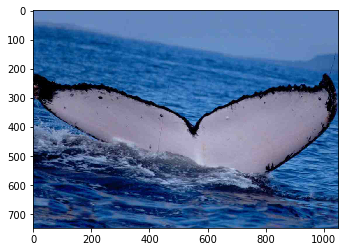

In [196]:
plt.imshow(img)

### Random rotation

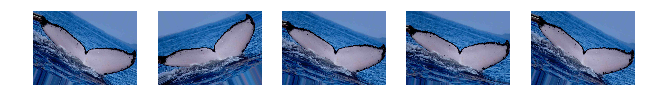

In [253]:
imgs = [
    random_rotation(img_arr, 30, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') * 255
    for _ in range(5)]
plot_images(imgs, None, rows=1)

### Random shift

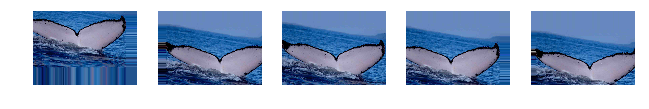

In [255]:
imgs = [
    random_shift(img_arr, wrg=0.1, hrg=0.3, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') * 255
    for _ in range(5)]
plot_images(imgs, None, rows=1)

### Random shear

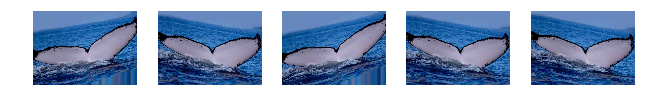

In [264]:
imgs = [
    random_shear(img_arr, intensity=0.4, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') * 255
    for _ in range(5)]
plot_images(imgs, None, rows=1)

### Random zoom

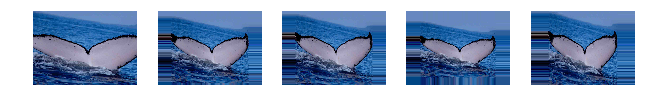

In [296]:
imgs = [
    random_zoom(img_arr, zoom_range=(1.5, 0.7), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest') * 255
    for _ in range(5)]
plot_images(imgs, None, rows=1)

### Grey scale

We want to ensure that all colour images also have a grey scale version.

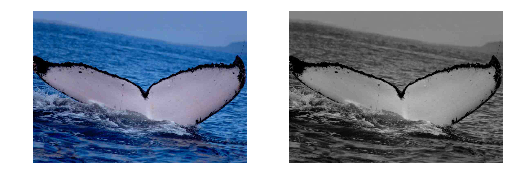

In [290]:
plot_images([img, img.convert('LA')], None, rows=1)

### Flips

Usually for side-on image sets like this we'd include a veritical flip, however, in this case the veritical alignment is requirement to differentiate between flutes, so I'll leave it out.